In [1]:
# export ort model with nms
!python3 export.py \
--weights yolov5s.pt \
--include onnx \
--nms ort \
--iou 0.65 \
--conf 0.25 \
--topk-all 300 \
--simplify

export: data=data/coco128.yaml, weights=['yolov5s.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=17, verbose=False, workspace=4, nms=ort, agnostic_nms=False, topk_per_class=100, topk_all=300, iou_thres=0.65, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-59-g91e2a54 Python-3.8.13 torch-1.13.1+cu117 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients

PyTorch: starting from yolov5s.pt with output shape (1, 25200, 85) (14.1 MB)

ONNX: starting export with onnx 1.13.0...
/home/ubuntu/workspace/github/yolo/yolov5/models/common.py:885: FutureWarning: 'torch.onnx._patch_torch._graph_op' is deprecated in version 1.13 and will be removed in version 1.14. Please note 'g.op()' is to be removed from torch.Graph. Please open a GitHub issue if you need this functionality..
  return g.op("NonMaxSuppression", boxes, scores, max_output_boxes_per_class, iou_thresho

In [2]:
import cv2
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path

In [3]:
w = "yolov5s.onnx"
providers = ['CPUExecutionProvider']
session = ort.InferenceSession(w, providers=providers)

names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

In [4]:
from utils.augmentations import letterbox

In [5]:
bgr = cv2.imread('data/images/bus.jpg')
draw_bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).copy()

bgr, ratio, dwdh = letterbox(bgr, auto=False)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

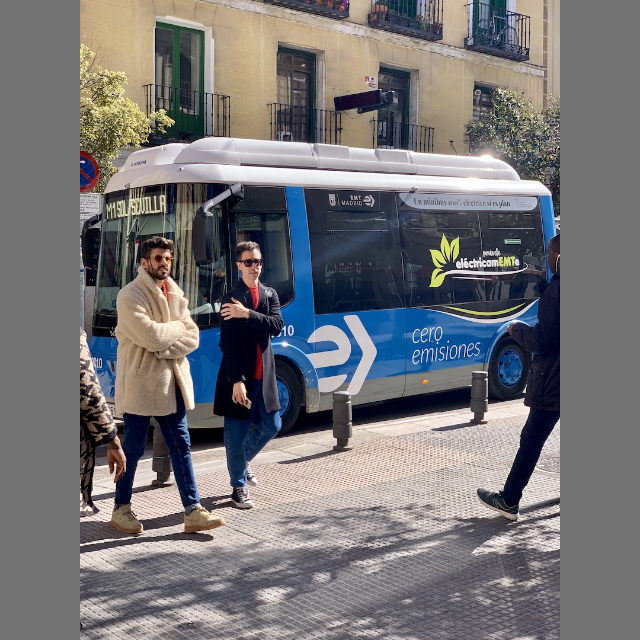

In [6]:
Image.fromarray(rgb)

In [7]:
# prepare input tensor
tensor = np.ascontiguousarray(rgb.transpose((2, 0, 1))[np.newaxis,...]).astype(np.float32) / 255
tensor.shape

(1, 3, 640, 640)

In [8]:
# model inference
out = session.run(None,{'images':tensor})

In [9]:
# batch size is 1, default using batch idx 0
out = [o[0] for o in out]

In [10]:
# the number of detection objects
out[0]

array([5], dtype=int64)

In [11]:
# bboxes of detection objects format x0y0x1y1
out[1]

array([[     210.89,      241.43,      284.87,      518.33],
       [     472.64,      228.84,      560.49,       521.7],
       [     114.12,      235.44,      207.29,      544.14],
       [     88.692,      131.67,      553.13,      465.11],
       [     79.405,      327.94,      122.94,      518.33],
       [          0,           0,           0,           0]], dtype=float32)

In [12]:
# scores of detection objects
out[2]

array([    0.83515,     0.82894,     0.78536,     0.78144,     0.46494,           0], dtype=float32)

In [13]:
# labels of detection objects
out[3]

array([ 0,  0,  0,  5,  0, -1], dtype=int64)

In [14]:
ratio, dwdh

((0.5925925925925926, 0.5925925925925926), (80.0, 0.0))

In [15]:
# postprocess bboxes
out[1] -= np.array(dwdh*2)
out[1] /= np.array(ratio*2)

In [16]:
for (box, score, label) in zip(*[o[:out[0][0]] for o in out[1:]]):
    box = box.round().astype(np.int32).tolist()
    cls_id = int(label)
    name = names[label]
    color = colors[name]
    cv2.rectangle(draw_bgr,box[:2],box[2:],color,2)
    cv2.putText(draw_bgr,f'{name}:{score:.3f}',(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)

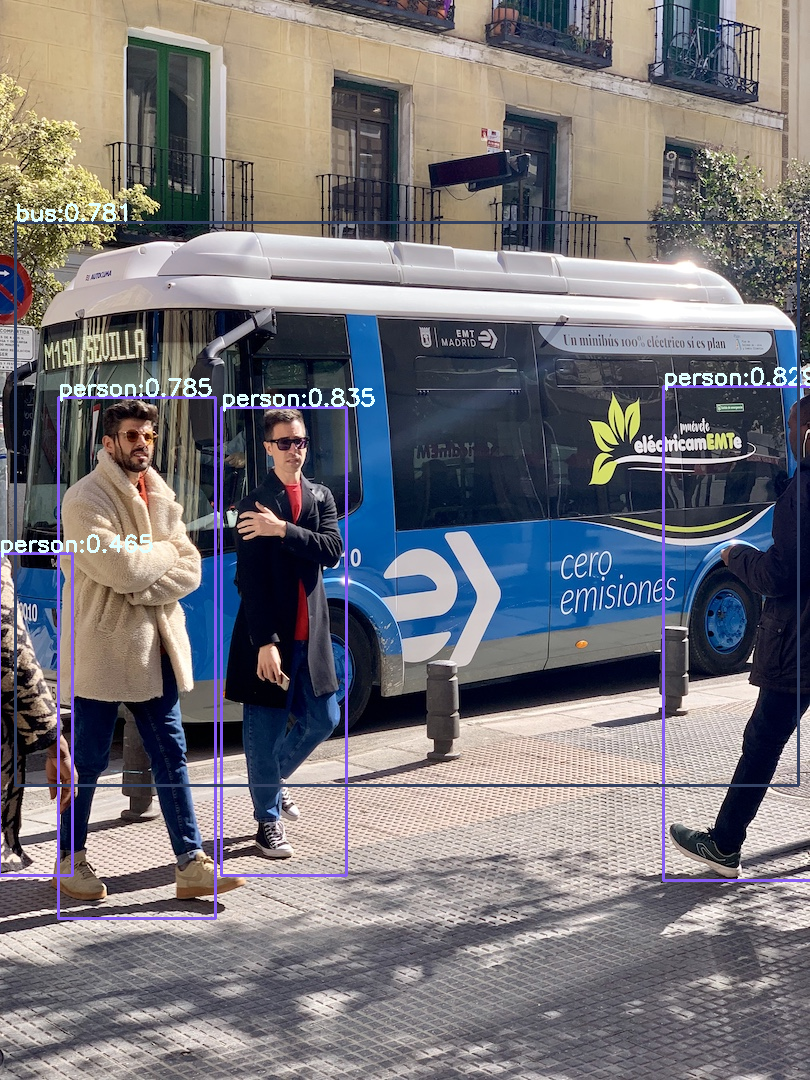

In [17]:
Image.fromarray(draw_bgr)